# Clustering analysis

This notebook contains attempts at unsupervised learning for a dataset containing audio features for 30,000 songs obtained from the Spotify API.

The goal is to identify natural groupings in the data, such that we can classify songs into moods based on their audio features.

Dataset: [30,000 Spotify songs](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs)

In [93]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import warnings
import umap.umap_ as umap

path_to_csv = '30000-spotify-songs/spotify_songs.csv'

In [94]:
# Load dataset

tracks_df = pd.read_csv(path_to_csv)
tracks_df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


Each track has the following features associated with it:

| Variable | Type | Description |
|----------|------|-------------|
| track_id | character | Song unique ID |
| track_name | character | Song Name |
| track_artist | character | Song Artist |
| track_popularity | double | Song Popularity (0-100) where higher is better |
| track_album_id | character | Album unique ID |
| track_album_name | character | Song album name |
| track_album_release_date | character | Date when album released |
| playlist_name | character | Name of playlist |
| playlist_id | character | Playlist ID |
| playlist_genre | character | Playlist genre |
| playlist_subgenre | character | Playlist subgenre |
| danceability | double | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | double | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| key | double | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| loudness | double | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| mode | double | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| speechiness | double | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| acousticness | double | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| instrumentalness | double | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | double | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| valence | double | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | double | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| duration_ms | double | Duration of song in milliseconds |

The features used to identify the tracks are not relevant for our analysis, so they can be dropped.

We are choosing to drop the genre features (`playlist_genre`, `playlist_subgenre`) as well. The reason for this is that our aim is to find natural grouping based solely on audio features, without having the genre influence our decisions. Inlcuding the genre will most likely lead to songs with similar genres being grouped together, regardless of the mood they evoke.

We are also choosing to drop `duration_ms`, as it is unlikely to affect the mood of a song.

In [95]:
track_features_df = tracks_df.drop(['track_id', 
                                   'track_name', 
                                   'track_artist', 
                                   'track_popularity', 
                                   'track_album_id', 
                                   'track_album_name', 
                                   'track_album_release_date', 
                                   'playlist_name', 
                                   'playlist_id', 
                                   'playlist_genre', 
                                   'playlist_subgenre',
                                   'duration_ms'], axis=1)

track_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036
1,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972
2,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008
3,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956
4,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976


Lets first normalize these features.

In [96]:
scaler = MinMaxScaler()
scaled_track_feat_df = pd.DataFrame(scaler.fit_transform(track_features_df), columns=track_features_df.columns)
scaled_track_feat_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.760936,0.915985,0.545455,0.918090,1.0,0.063508,0.102616,0.000000,0.065562,0.522704,0.509673
1,0.738555,0.814968,1.000000,0.869162,1.0,0.040632,0.072837,0.004235,0.358434,0.699294,0.417524
2,0.686673,0.930988,0.090909,0.901368,0.0,0.080828,0.079879,0.000023,0.110442,0.618567,0.517908
3,0.730417,0.929988,0.636364,0.894118,1.0,0.111111,0.028873,0.000009,0.204819,0.279516,0.509338
4,0.661241,0.832971,0.090909,0.875385,1.0,0.039107,0.080785,0.000000,0.083635,0.731584,0.517775


Lets now compute variances for each feature,this can tell us if there are any uninformative features (i.e. low variance).

mode                0.245690
key                 0.107802
valence             0.055349
instrumentalness    0.050888
acousticness        0.048823
energy              0.032740
liveness            0.024005
danceability        0.021784
tempo               0.012625
speechiness         0.012180
loudness            0.003921
dtype: float64


Text(0.5, 1.0, 'Variance Analysis')

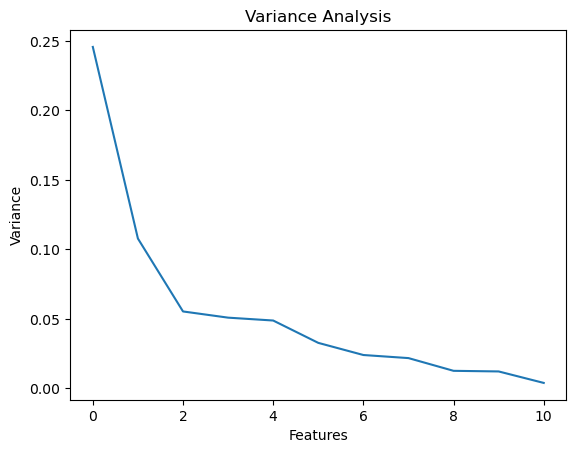

In [97]:
variances = pd.DataFrame(scaled_track_feat_df, columns=scaled_track_feat_df.columns).var().sort_values(ascending=False)
print(variances)
plt.plot(variances.values)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance Analysis')

As we can see, the loudness feature has very low variance (0.0039) i.e. it is a good candidate for removal.

In [98]:
scaled_track_feat_df = scaled_track_feat_df.drop(['loudness'], axis=1)
scaled_track_feat_df.head()

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.760936,0.915985,0.545455,1.0,0.063508,0.102616,0.000000,0.065562,0.522704,0.509673
1,0.738555,0.814968,1.000000,1.0,0.040632,0.072837,0.004235,0.358434,0.699294,0.417524
2,0.686673,0.930988,0.090909,0.0,0.080828,0.079879,0.000023,0.110442,0.618567,0.517908
3,0.730417,0.929988,0.636364,1.0,0.111111,0.028873,0.000009,0.204819,0.279516,0.509338
4,0.661241,0.832971,0.090909,1.0,0.039107,0.080785,0.000000,0.083635,0.731584,0.517775



Before we proceed any further, let us first see if there are any highly correlated features that can potentially be dropped. We can compute a correlation matrix for the features.

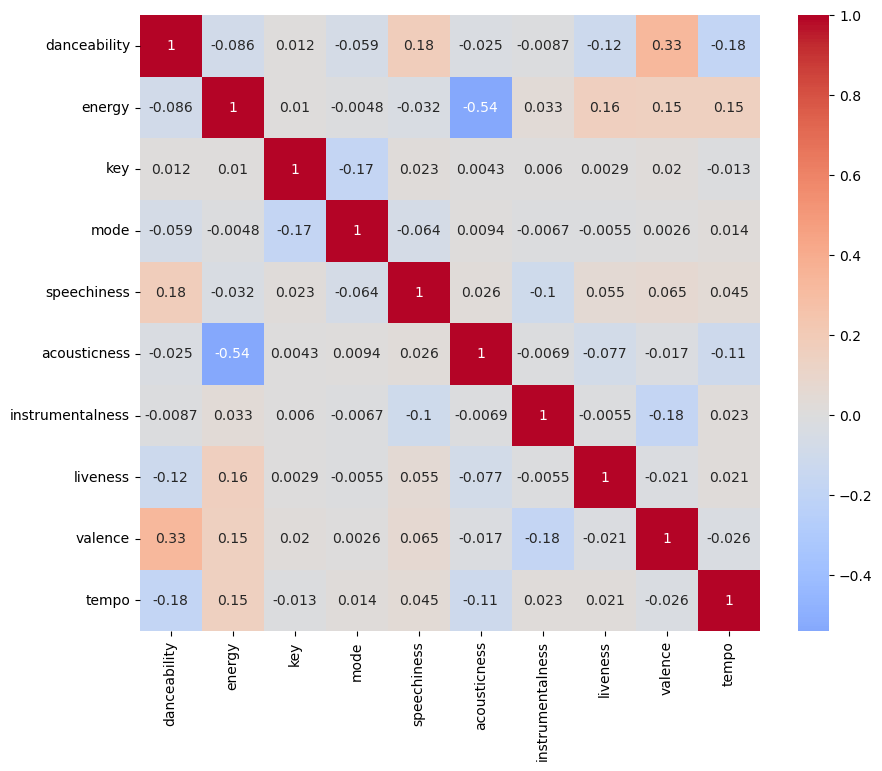

In [99]:
correlation_matrix = scaled_track_feat_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

We see that there are no highly correlated features (the highest being between acousticness and energy).

Now, lets try to find the optimal number of clusters using the elbow method.


In [100]:
X = scaled_track_feat_df.values

In [101]:
wcss = {}
silhouette_scores = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(2, 20):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
        kmeans.fit(X)
        wcss[i] = kmeans.inertia_
        silhouette_scores[i] = silhouette_score(X, kmeans.labels_)

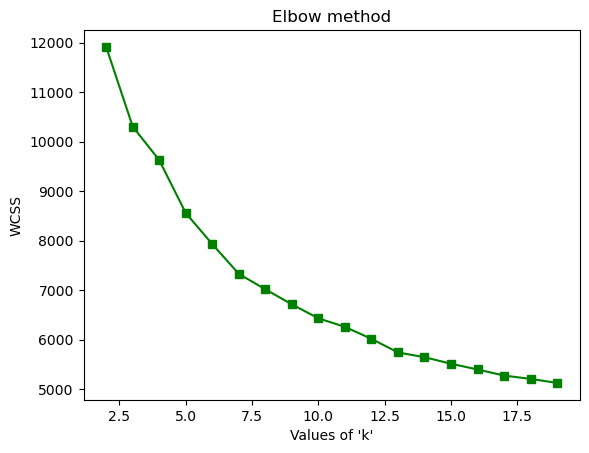

In [102]:
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.title('Elbow method')
plt.show()

           0
2   0.385681
3   0.289339
4   0.285347
5   0.223952
6   0.233612
7   0.242726
8   0.213416
9   0.192000
10  0.173349
11  0.174746
12  0.166841
13  0.168099
14  0.158216
15  0.155666
16  0.157015
17  0.158933
18  0.157185
19  0.154348


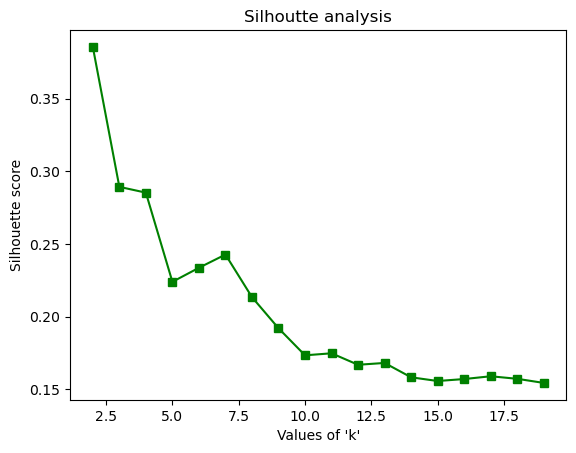

In [103]:
print(pd.DataFrame(silhouette_scores.values(), index=silhouette_scores.keys()))
plt.plot(silhouette_scores.keys(), silhouette_scores.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('Silhouette score')
plt.title('Silhoutte analysis')
plt.show()

From our results we see that even at best (2 clusters) we only get a silhouette score of 0.38. This, along with the lack of a clear elbow suggest that K-Means might not be well suited to our problem. Thus, lets try a different clustering technique, **DBSCAN!**

Before we can implement clustering using DBSCAN, we need to find good values for parameters `eps` and `min_samples`.

For `min_samples` a good heuristic is to try out values between D + 1 and 2 times D or 4 times D where D is the number of dimensions of our data. This would be 11, 20 and 40 in our case.

For `eps` we can plot the k-distance graph, and look for the elbow point.
The k-distance graph is essentially a plot of the distance of each data point from its closest neighbor.

In [104]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances in ascending order
distances = np.sort(distances[:, 1])  # Get distances to 2nd nearest neighbor

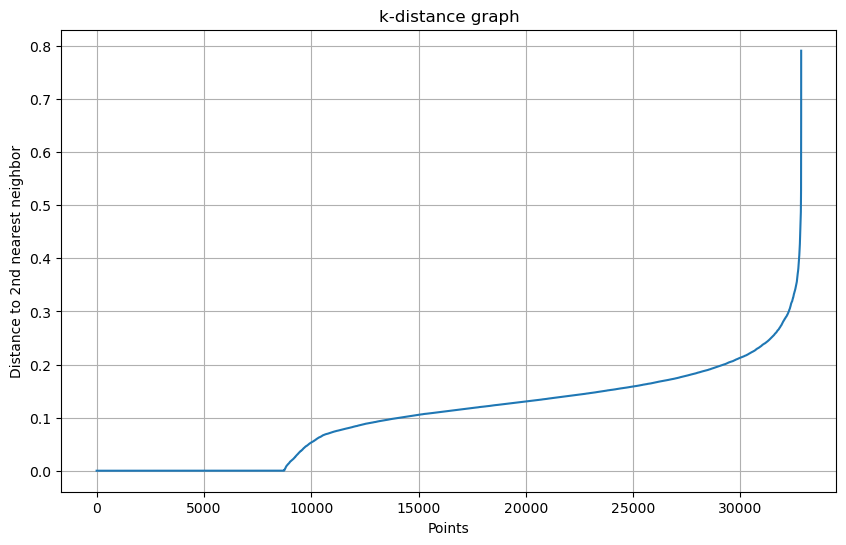

In [105]:
# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.xlabel('Points')
plt.ylabel('Distance to 2nd nearest neighbor')
plt.title('k-distance graph')

# Look for the "elbow" in the curve
plt.grid(True)
plt.show()

From the graph we can see that there are two major elbows, around distance values 0.1 and 0.3. These represent density transitions in our data. But 0.3 seems to be too large of a value for eps, as most of the points fall below it, and might lead to merging of clusters. Lets try values around 0.1.

In [106]:
eps_values = [0.08, 0.1, 0.12, 0.15]
min_samples_values = [11, 15, 20, 25, 30, 35, 40]

results = []

for eps in eps_values:
    num_clusters = {}
    num_noise = {}
    silhouette_scores = {}
    print("Current eps:", eps)
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        # Skip if all points are noise
        if len(np.unique(labels)) < 2:
            print("All noise for", min_samples)
            continue

        # Calculate metrics
        num_clusters[min_samples] = len(np.unique(labels[labels != -1]))
        num_noise[min_samples] = sum(labels == -1)

        # Calculate silhouette score (excluding noise points)
        if -1 in labels:
            silhouette_scores[min_samples] = silhouette_score(X[labels != -1], 
                                        labels[labels != -1])
        else:
            silhouette_scores[min_samples] = silhouette_score(X, labels)
    results.append([num_clusters, num_noise, silhouette_scores])

Current eps: 0.08
All noise for 15
All noise for 20
All noise for 25
All noise for 30
All noise for 35
All noise for 40
Current eps: 0.1
All noise for 20
All noise for 25
All noise for 30
All noise for 35
All noise for 40
Current eps: 0.12
All noise for 35
All noise for 40
Current eps: 0.15


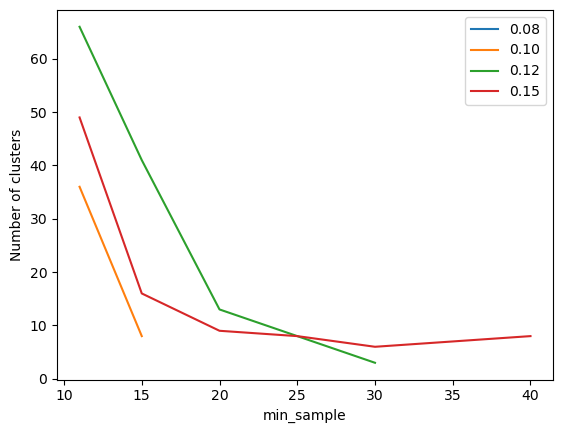

In [107]:
for i in range(len(eps_values)):
    plt.plot(results[i][0].keys(), results[i][0].values(), label="{:.2f}".format(eps_values[i]))
plt.legend()
plt.xlabel('min_sample')
plt.ylabel('Number of clusters')
plt.show()

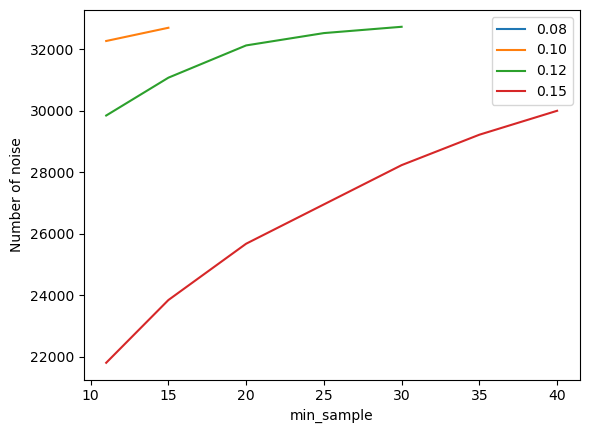

In [108]:
for i in range(len(eps_values)):
    plt.plot(results[i][1].keys(), results[i][1].values(), label="{:.2f}".format(eps_values[i]))
plt.legend()
plt.xlabel('min_sample')
plt.ylabel('Number of noise')
plt.show()

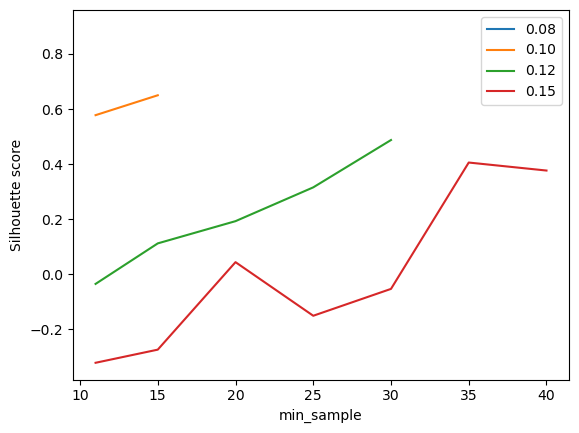

In [109]:
for i in range(len(eps_values)):
    plt.plot(results[i][2].keys(), results[i][2].values(), label="{:.2f}".format(eps_values[i]))
plt.legend()
plt.xlabel('min_sample')
plt.ylabel('Silhouette score')
plt.show()

Based on these plots, we can see that there is practically no combination of eps and min_sample values that can give us a desirable result. We always end up with high noise percentage.

DBSCAN proved unsuitable for this audio feature dataset for several reasons:
1. With various combinations of eps (0.08-0.15) and min_samples (11-40), the majority of data points (>80%) were classified as noise
2. The high dimensionality (10 features) and continuous nature of audio characteristics made it difficult to find dense regions
3. No parameter combination achieved both good cluster separation and reasonable noise ratio


Given that we're working with audio features for mood classification, where characteristics exist on a continuous spectrum rather than in distinct clusters, let try a soft clustering appriach, which will allow tracks to belong to multiple moods, such as **Gaussian Mixture Models (GMM)**.

But first, we need to find the optimal number of components to use with GMM. For this, we are going to puse the elbow method with BIC/AIC score for GMM in a range of values for `n_components`.

In [110]:
bic_scores = {}
aic_scores = {}
for i in range(2, 21):
    gmm = GaussianMixture(n_components=i, random_state=1)
    gmm.fit(X)
    
    # Calculate BIC and AIC scores
    bic_scores[i] = gmm.bic(X)
    aic_scores[i] = gmm.aic(X)

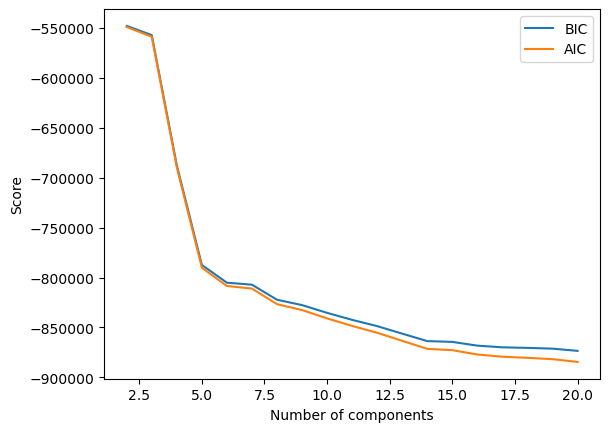

In [112]:
plt.plot(bic_scores.keys(), bic_scores.values(), label='BIC')
plt.plot(aic_scores.keys(), aic_scores.values(), label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.legend()
plt.show()

As we can see, both the plots have the elbow point at 5 components, beyond which we get diminishing returns. Let us now perform clustering using GMM with `n_components=5`.

In [113]:
gmm = GaussianMixture(n_components=5, random_state=1)
gmm.fit(X)

GaussianMixture(n_components=5, random_state=1)

Let us now try to see the silhouette score.

In [114]:
cluster_labels = gmm.predict(X)
print(silhouette_score(X, cluster_labels))

0.09928153639090193


As we can see, the silhouette score is very low! But this might simply be because slihouette score is a metric that is best suited for hard clustering methods, and is not as applicable to soft clustering methods such as GMM. As an alternative evaluation metric, lets try to analyze the feature distribution across clusters.

Cluster Centers (Mean Values):
         danceability    energy       key  mode  speechiness  acousticness  \
Cluster                                                                      
0            0.676539  0.737825  0.086568   1.0     0.134393      0.045435   
1            0.680506  0.692690  0.547954   0.0     0.135987      0.180744   
2            0.647601  0.722070  0.436319   1.0     0.085471      0.156810   
3            0.657270  0.674242  0.556434   1.0     0.113122      0.231408   
4            0.663050  0.719614  0.570975   0.0     0.091468      0.154374   

         instrumentalness  liveness   valence     tempo  
Cluster                                                  
0                0.000371  0.199832  0.538680  0.512361  
1                0.000275  0.191246  0.535914  0.500963  
2                0.347455  0.191611  0.449584  0.512830  
3                0.000287  0.186378  0.536078  0.501454  
4                0.340261  0.193892  0.451943  0.508995  


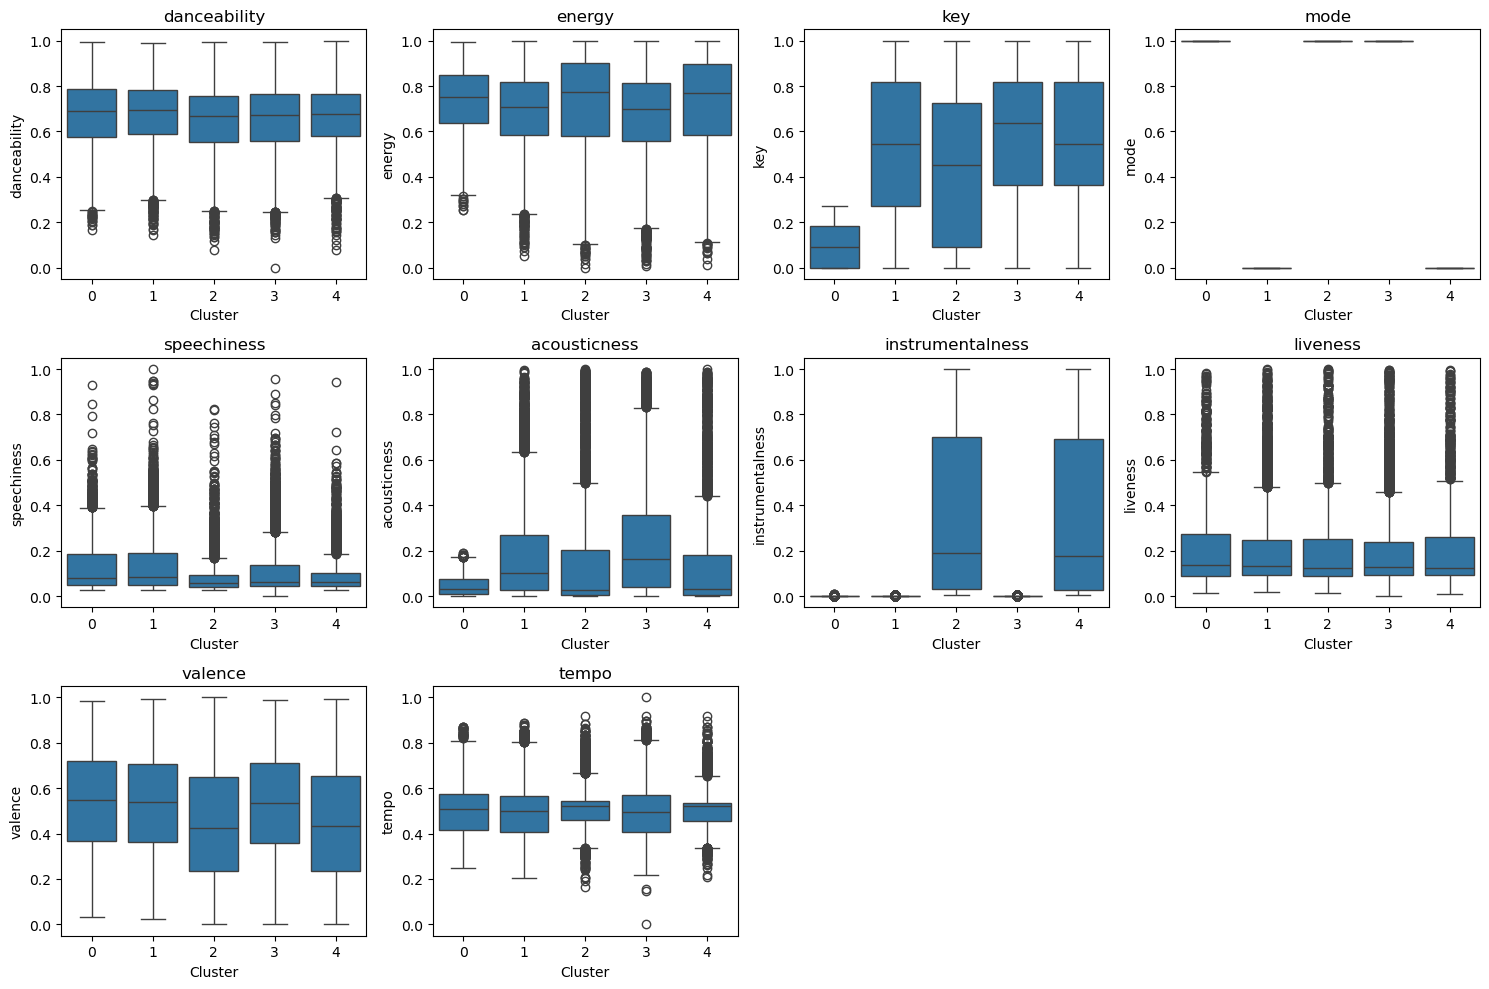

In [115]:
df = pd.DataFrame(X, columns=scaled_track_feat_df.columns)
df['Cluster'] = cluster_labels

cluster_means = df.groupby('Cluster').mean()
print("Cluster Centers (Mean Values):")
print(cluster_means)

# Create boxplots for each feature across clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(feature)
plt.tight_layout()
plt.show()

Disappointing results once again :(

There are barely any defining characteristics for the clusters, and the distributions are pretty homogeneous across clusters.

The initial clustering attempts using all 10 audio features showed limited success:
- K-means and DBSCAN struggled to find meaningful clusters
- GMM with all features resulted in highly overlapping clusters with homogeneous feature distributions
- Low silhouette scores and high proportion of noise points (in DBSCAN) suggest poor cluster separation

After reviewing music emotion research literature, a more focused approach using the Valence-Arousal (VA) space appears more suitable for mood classification. This well-established framework suggests that musical emotion can be effectively captured using just two primary dimensions:
- Valence: representing the positivity/negativity of the emotion
- Energy (Arousal): representing the intensity/activation level

Read more: https://www.researchgate.net/publication/307909024_Music_Emotion_Maps_in_Arousal-Valence_Space

Instead of using all features for clustering, we will:
1. Perform GMM clustering using only valence and energy features
2. Use the remaining features (acousticness, instrumentalness, etc.) to analyze the musical characteristics within each mood cluster, providing additional context about how different moods are expressed musically

In [116]:
va_only_df = scaled_track_feat_df[['valence', 'energy']]
va_only_df.head()

,valence,energy
0,0.522704,0.915985
1,0.699294,0.814968
2,0.618567,0.930988
3,0.279516,0.929988
4,0.731584,0.832971


In [117]:
X = va_only_df.values

Once again, we must find the optimal number of components

In [118]:
bic_scores = {}
aic_scores = {}
for i in range(2, 21):
    gmm = GaussianMixture(n_components=i, random_state=1)
    gmm.fit(X)
    
    # Calculate BIC and AIC scores
    bic_scores[i] = gmm.bic(X)
    aic_scores[i] = gmm.aic(X)

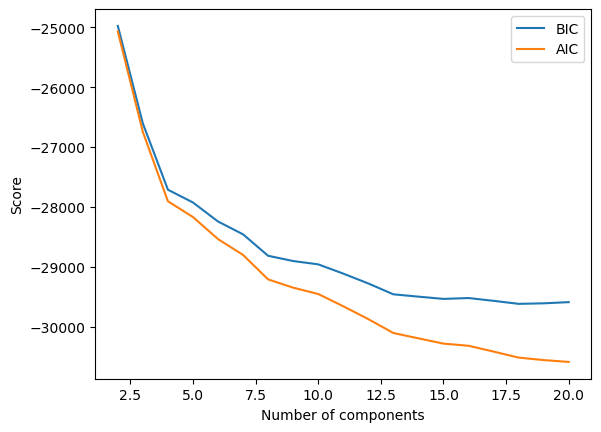

In [119]:
plt.plot(bic_scores.keys(), bic_scores.values(), label='BIC')
plt.plot(aic_scores.keys(), aic_scores.values(), label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.legend()
plt.show()

As we can see, we have elbows around 4, 8 and 13 components. The one at 4 components is to be expected, as in the VA space there are 4 mood categories:
1. High valence - High Arousal
2. High valence - Low Arousal
3. Low valence - High Arousal
4. Low valence - Low Arousal

Thus, lets perform clustering with 4 components, as it aligns with our expected clustering of the space.

In [120]:
# Performing GMM clustering with 4 components

gmm = GaussianMixture(n_components=4, random_state=1)
gmm.fit(X)

GaussianMixture(n_components=4, random_state=1)

In [121]:
cluster_labels = gmm.predict(X)
cluster_means = gmm.means_

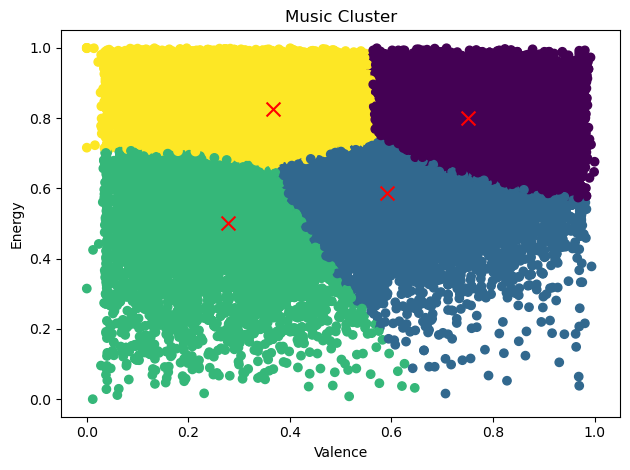

In [122]:
# Scatter plot
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels)
plt.scatter(cluster_means[:, 0], cluster_means[:, 1], marker='x', s=100, c='red')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.title('Music Cluster')
plt.tight_layout()

The above visualisation clearly shows the distinct clusters we have obtained in our expected regions, vouching for the effectiveness of our clustering. But it doesn't quite capture the continuous nature of our clustering. GMM gives us the probabilities of each data point belonging to a certain cluster, the above visualisation is a result of simply assigning the point to the cluster of highest probability. Let us now create a visualisation that shows the uncertainty in the cluster assignments of each data point.

In [91]:
# Get probability assignments for each point
probs = gmm.predict_proba(X)

# Calculate uncertainty (entropy)
uncertainty = -np.sum(probs * np.log(probs + 1e-10), axis=1)
uncertainty = uncertainty / np.log(gmm.n_components)  # normalize

# Create a mesh grid
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Compute log probability density
Z = gmm.score_samples(mesh_points)
Z = Z.reshape(xx.shape)

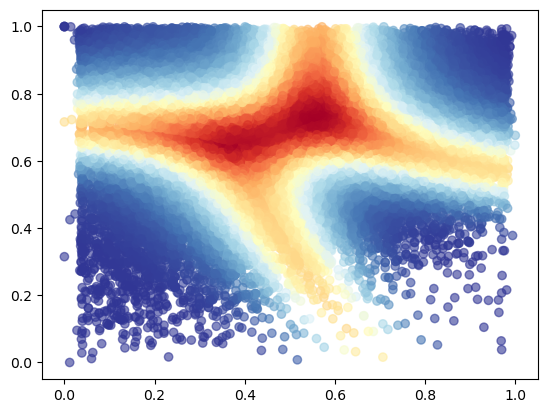

In [92]:
for i in range(gmm.n_components):
    mask = cluster_labels == i
    plt.scatter(X[mask, 0], X[mask, 1], 
               c=uncertainty[mask],
               cmap='RdYlBu_r',
               alpha=0.6,
               label=f'Cluster {i+1}')

As we can see, the data points near the cluster boundaries have high uncertainty (red), shown by the red cross. This is to be expected as well, since these data points can belong to either cluster along the boundary with good probability.

Finally! Great success :)

But we are not done yet, we must create a cluster to mood mapping that makes sense, and add these moods to our data set. 

Additionally, we should also consider adding the remaining features when analyzing our clusters.

So, next steps:

1. Label the dataset using this clustering
2. Analyze distributions of remaining features in our clusters, to create "sub-moods"
3. Train a supervised model on our pseudo-labeled data to make the same predictions for unseen data.
